<a href="https://colab.research.google.com/github/ssblk/Breast-cancer-classification-/blob/main/efficentnetb7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import numpy as np
from tqdm import tqdm
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import skimage.io
import skimage.color
import skimage.filters 
from skimage import (restoration, util)
import imageio
import pywt
from numpy import asarray
from numpy import clip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten ,Dropout ,Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential



In [ ]:
import patoolib
patoolib.extract_archive("data.zip", outdir="/home/abdo/workspace/")

patool: Extracting data.zip ...
patool: ... data.zip extracted to `/home/abdo/workspace/'.


'/home/abdo/workspace/'

# Loading images

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG


benign = np.array(Dataset_loader('/home/abdo/workspace/data/Benign',175))
malign = np.array(Dataset_loader('/home/abdo/workspace/data/Malignant',175))

100%|██████████| 3503/3503 [00:02<00:00, 1547.62it/s]


In [ ]:
benign.shape[0]

3583

In [ ]:
malign.shape[0]

3502

# Preprocessing

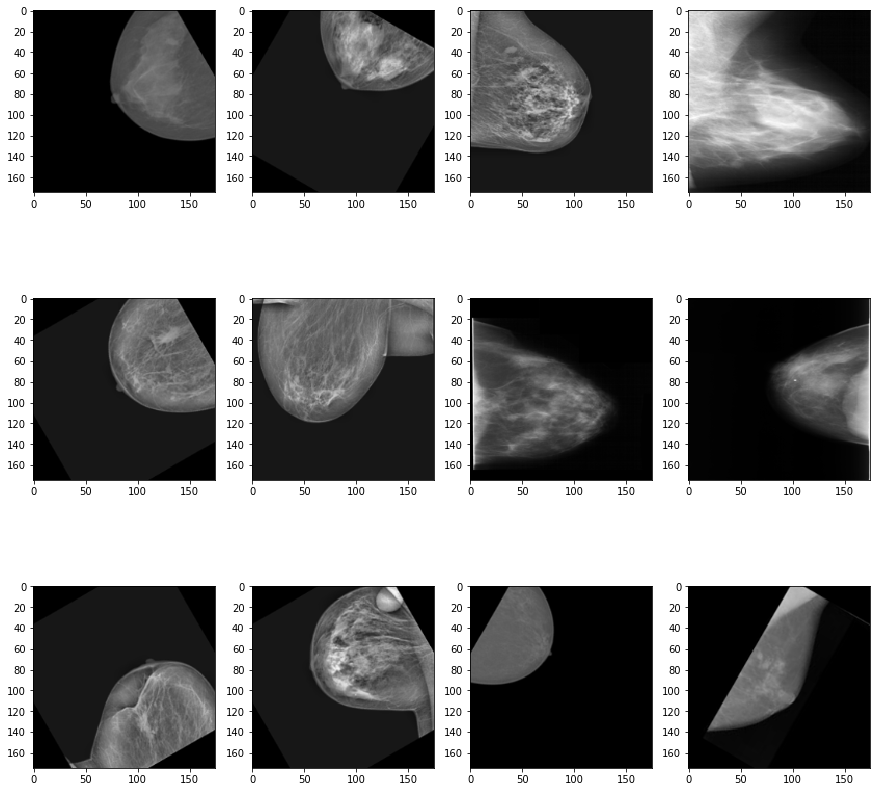

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(benign[i], interpolation='nearest', cmap="gray")
plt.show()

### 1- Background removal

In order to pre-process the images we have to 
first remove the background to avoid some 
potential noise the upcoming steps. We used 
the threshold method.

In [ ]:
benign_pr = []
malign_pr = []

for i in range(benign.shape[0]): 
    # convert the image to grayscale
    gray_image = cv2.cvtColor(benign[i], cv2.COLOR_BGR2GRAY)
    # blur the image to denoise
    blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)
    t = skimage.filters.threshold_otsu(blurred_image)
    binary_mask = blurred_image > t
    
    selection = np.zeros_like(benign[i])
    selection[binary_mask] = benign[i][binary_mask]
    
    benign_pr.append(selection)

for i in range(malign.shape[0]): 
    # convert the image to grayscale
    gray_image = cv2.cvtColor(malign[i], cv2.COLOR_BGR2GRAY)
    # blur the image to denoise
    blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)
    
    t = skimage.filters.threshold_otsu(blurred_image)
    binary_mask = blurred_image > t
    
    selection = np.zeros_like(malign[i])
    selection[binary_mask] = malign[i][binary_mask]
    
    malign_pr.append(selection)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


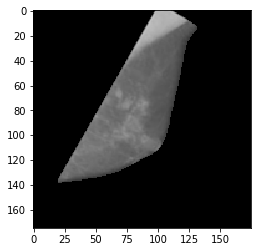

In [ ]:
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(benign_pr[i], interpolation='nearest', cmap="gray")
plt.show()

### 2- CALHE

In [ ]:
benign_calhe = []
malign_calhe = []

clahe=cv2.createCLAHE(clipLimit=3)
for i in range(benign.shape[0]):
    grayimg = cv2.cvtColor(benign_pr[i], cv2.COLOR_BGR2GRAY)
    benign_calhe.append(clahe.apply(grayimg))
    
for i in range(malign.shape[0]):
    grayimg = cv2.cvtColor(malign_pr[i], cv2.COLOR_BGR2GRAY)
    malign_calhe.append(clahe.apply(grayimg))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


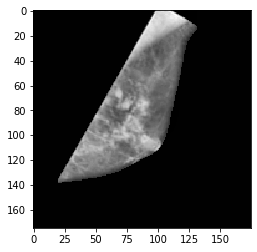

In [ ]:
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(benign_calhe[i], interpolation='nearest', cmap="gray")
plt.show()

### 3- Data Augmentation

#### 3.1 - Adding Gaussian Noise

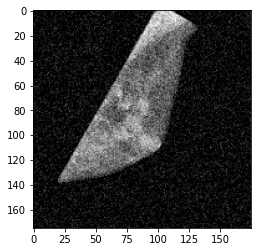

In [ ]:
from skimage.util import random_noise

noise_img = random_noise(benign_calhe[12], mode='gaussian')

noise_img = np.array(100*noise_img, dtype = 'uint8')
plt.imshow(noise_img,cmap='gray')

#### 3.2 - Flipping and rotating

In [ ]:
# Using original generator
train_generator = ImageDataGenerator(rotation_range = 90,horizontal_flip=True,vertical_flip=True,featurewise_center=True,
    featurewise_std_normalization=True,)

In [ ]:
benign_f = []
malign_f = []

#Back to RGB
for i in range(benign.shape[0]):
    benign_f.append(cv2.cvtColor(benign_calhe[i],cv2.COLOR_GRAY2RGB))

for i in range(malign.shape[0]):
    malign_f.append(cv2.cvtColor(malign_calhe[i],cv2.COLOR_GRAY2RGB))

# Labeling the data

In [ ]:
benign_train, benign_test =train_test_split(benign_f,test_size=0.15, shuffle=True)
malign_train, malign_test = train_test_split(malign_f,test_size=0.15, shuffle=True)

# Create labels

benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
x_test = X_test[s]
y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train, Test and Validation split
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.15, 
    random_state=11
)

print(x_train.shape), print(y_train.shape)
print(x_val.shape), print(y_val.shape)
print(x_test.shape), print(y_test.shape)


(5117, 175, 175, 3)
(5117, 2)
(904, 175, 175, 3)
(904, 2)
(1064, 175, 175, 3)
(1064,)


(None, None)

# Building EfficientNetB7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
# Init the VGG model
EfficientNetB7= EfficientNetB7(weights='imagenet', include_top=False, input_shape=(175,175, 3))

# Freeze all the layers
for layer in EfficientNetB7.layers[:]:
    layer.trainable = False

In [ ]:
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(EfficientNetB7)

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 6, 6, 2560)        64097687  
_________________________________________________________________
flatten (Flatten)            (None, 92160)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              94372864  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 158,472,601
Trainable params: 94,374,914
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)
mcp = ModelCheckpoint('resnet.h5',vrbose=1)
es = EarlyStopping(verbose=1, patience=5)



In [ ]:
with tf.device('/device:GPU:0'):
    model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)
    %time
    from tensorflow.keras import backend as K
    history = model.fit( x_train, y_train, verbose = 1,epochs=100,validation_data=(x_val,y_val))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.9 µs
Epoch 1/100
160/160 [==============================] - 242s 1s/step - loss: 7.3437 - accuracy: 0.6605 - precision: 0.6606 - recall: 0.6600 - auc: 0.6809 - f1_score: 0.6581 - val_loss: 0.3819 - val_accuracy: 0.8341 - val_precision: 0.8254 - val_recall: 0.8473 - val_auc: 0.9137 - val_f1_score: 0.8361
Epoch 2/100
160/160 [==============================] - 225s 1s/step - loss: 0.4417 - accuracy: 0.8073 - precision: 0.8044 - recall: 0.8121 - auc: 0.8877 - f1_score: 0.8081 - val_loss: 0.3085 - val_accuracy: 0.8800 - val_precision: 0.8890 - val_recall: 0.8684 - val_auc: 0.9479 - val_f1_score: 0.8814
Epoch 3/100
160/160 [==============================] - 224s 1s/step - loss: 0.3949 - accuracy: 0.8176 - precision: 0.8149 - recall: 0.8219 - auc: 0.9060 - f1_score: 0.8184 - val_loss: 0.3197 - val_accuracy: 0.8468 - val_precision: 0.8495 - val_recall: 0.8429 - val_auc: 0.9366 - val_f1_score: 0.8468
Epoch 4/100
160/160 [===============

In [ ]:
model.save("EfficientNetB7.h5")

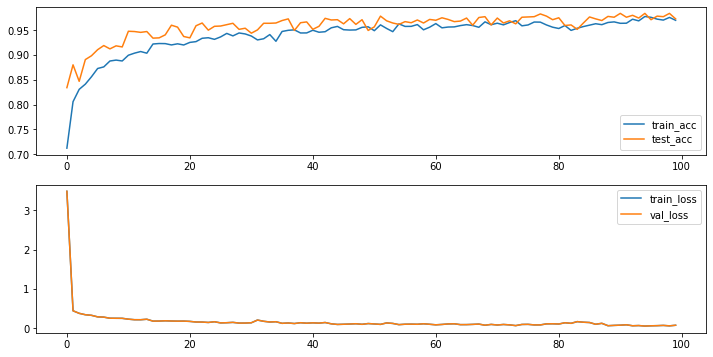

In [ ]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['loss'], label = "val_loss")
plt.legend()

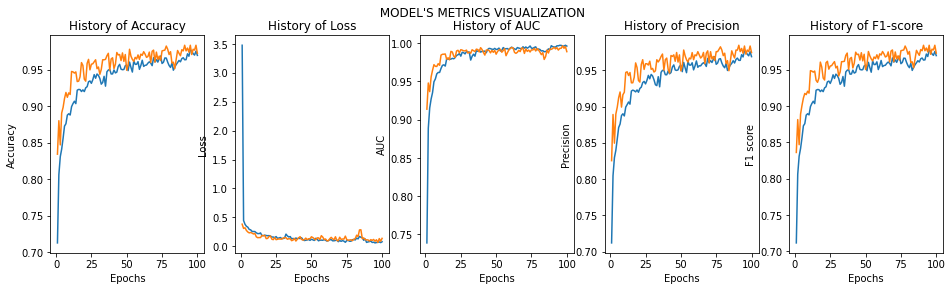

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    #ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    #ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title(' History of AUC ')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('AUC')
    #ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    #ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    #ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

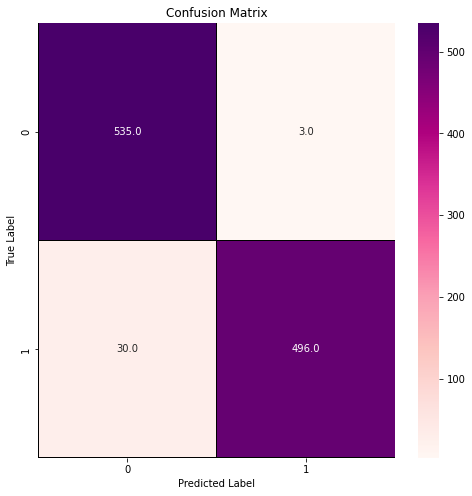

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="RdPu",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

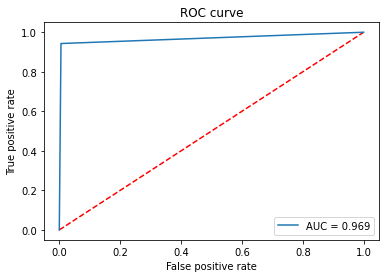

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [ ]:
efficientB7_auc=roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

In [ ]:
efficientB7_auc

0.968694785644621

In [ ]:
Y_pred

array([[1.0000000e+00, 2.9261853e-12],
       [1.0000000e+00, 7.7119417e-16],
       [9.9999970e-01, 2.2491652e-06],
       ...,
       [6.8145789e-10, 1.0000000e+00],
       [6.9569315e-09, 9.9999893e-01],
       [5.4520785e-12, 1.0000000e+00]], dtype=float32)

In [ ]:
import sklearn.metrics as metrics
target=["B","M"]
print('Accuracy:', np.round(metrics.accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)),4))
print('F1 Score:', np.round(metrics.f1_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1), average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)),4))
print('Recall:', np.round(metrics.recall_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1), average='weighted'),4))
print('Precision:', np.round(metrics.precision_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1), average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1),target_names=target))

Accuracy: 0.969
F1 Score: 0.969
Cohen Kappa Score: 0.9379
Recall: 0.969
Precision: 0.9702
		Classification Report:
               precision    recall  f1-score   support

           B       0.95      0.99      0.97       538
           M       0.99      0.94      0.97       526

    accuracy                           0.97      1064
   macro avg       0.97      0.97      0.97      1064
weighted avg       0.97      0.97      0.97      1064

